In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import skimage.io as io

from di_dataset3 import DepthImageDataset, collate_batch

2022-03-10 14:24:11.638076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/patricknit/.mujoco/mjpro150/bin
2022-03-10 14:24:11.638092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C

In [13]:
import os

base_path = "/home/patricknit/vae_models/"
for file in os.listdir(base_path):
    if "vae_dronet_sigmoid_MSE_weighted_filtered_new" in file:
        #print(file[:file.rfind("_")])
        #print(file[file.rfind("_"):])
        os.rename(base_path+file, base_path+"vae_dronet_sigmoid_new_MSE_noWeight_filtered" + file[file.rfind("_"):])

In [35]:
LINUX = False

latent_dim = 64
num_epochs = 250
batch_size = 32
learning_rate = 1e-3

save_model = False
load_model = False

if LINUX:
    tfrecord_folder = "/home/patricknit/rl_data/tfrecord_wfiltered"
    tfrecord_test_folder = "/home/patricknit/rl_data/tfrecord_wfiltered/test"

    save_model_file = "/home/patricknit/vae_models/vae_dronet_sigmoid_MSE_weighted"
    load_model_file = "/home/patricknit/vae_models/vae_dronet_sigmoid_MSE_weighted_90.pth"

else:
    base_path = "/Users/patricknitschke/Library/CloudStorage/OneDrive-NTNU/NTNU/Kybernetikk og robotikk/Master/Thesis/Code"
    tfrecord_folder = base_path + "/rl_data/tfrecord_wfiltered"
    tfrecord_test_folder = tfrecord_folder + "/test"
    
    save_model_file = base_path + "/vae_models/vae_dronet_sigmoid_MSE_weighted_filtered"
    load_model_file = base_path + "/vae_models/vae_dronet_sigmoid_MSE_weighted_filtered_140.pth"
    

In [36]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True) # 180 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size, one_tfrecord=True) # 20 tfrecords

Loading tfrecords... 	['/Users/patricknitschke/Library/CloudStorage/OneDrive-NTNU/NTNU/Kybernetikk og robotikk/Master/Thesis/Code/rl_data/tfrecord_wfiltered/data105.tfrecords']
Metal device set to: Apple M1


2022-03-09 22:52:15.533559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 22:52:15.534212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-09 22:52:15.658598: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Iterating length... 	Done: 64
Loading tfrecords... 	['/Users/patricknitschke/Library/CloudStorage/OneDrive-NTNU/NTNU/Kybernetikk og robotikk/Master/Thesis/Code/rl_data/tfrecord_wfiltered/test/data194.tfrecords']
Iterating length... 	Done: 71


In [37]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

In [44]:
images, images_filtered, *_ = next(iter(test_loader))

gotcha


# Model

In [40]:
from vae_dronet import VAE

In [42]:
vae_model = VAE(n_z=64)

load_model = True

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    vae_model.eval()
else:
    vae_model.train()


[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model


# Test

In [45]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

- Before encoding, mean: 0.454 var: 0.110
- After deconv 7, mean: -0.037 var: 11.625
- After sigmoid, mean: 0.389 var: 0.094


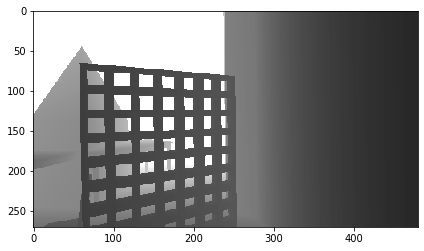

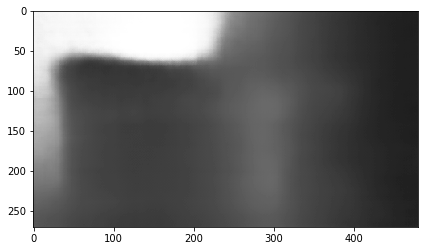

In [49]:
vae_model.eval()
with torch.no_grad():
    img_recon, means, logvar, z = vae_model(images)

idx = 5
imshow(images[idx])
imshow(img_recon[idx])

# Weights

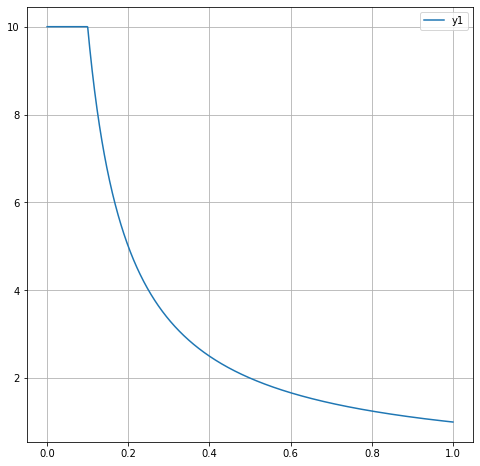

In [50]:
def depth_func1(x):
    return np.minimum(1/(x+0.0001), 10*np.ones_like(x))

def depth_func2(x):
    return 2**(-3*(x-0.1))

def depth_func3(x):
    return 1/(x+.5) - .5

import time
x = np.arange(0, 1.001, 0.001)
t1 = []
t2 = []
t3 = []
y1 = depth_func1(x)

plt.figure(figsize=(8, 8))
plt.plot(x, y1)
plt.grid()
plt.legend(["y1"])
plt.show()

# Check

In [97]:
def mse_loss(x, x_hat, mu, logvar):
    reproduction_loss = F.mse_loss(x_hat, x, reduction="mean") * (270 * 480)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss + kl_divergence, kl_divergence, reproduction_loss

def mse_loss2(x, x_hat, mu, logvar):
    reproduction_loss = (depth_func1(x) * (x_hat - x)**2).mean() * (270 * 480)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss + kl_divergence, kl_divergence, reproduction_loss

In [98]:
mse_loss(images, img_recon, means, logvar)

(tensor(4922.0889), tensor(2281.2151), tensor(2640.8738))

In [94]:
mse_loss2(images, img_recon, means, logvar)

(tensor(5800.1094), tensor(2281.2151), tensor(3518.8945))